In [1]:
from qibolab import Platform
import diagnostics

[Qibo 0.1.6|INFO|2022-03-28 17:40:02]: Using numpy backend on /CPU:0
[Qibo 0.1.6|WARNING|2022-03-28 17:40:02]: numpy backend uses `np.einsum` and supports CPU only. Consider installing the qibojit or qibotf backends for increased performance and to enable GPU acceleration.


In [2]:
# Create a platform; connect and configure it
platform = Platform('tiiq')
platform.connect()
platform.setup()

# create a diagnostics object
ds = diagnostics.Diagnostics(platform)

# Characterisation can be done by changing settings to qibolab/runcards/tiiq.yml and diagnostics.yml

[Qibo 0.1.6|INFO|2022-03-28 17:40:07]: Loading platform tiiq
[Qibo 0.1.6|INFO|2022-03-28 17:40:07]: Loading runcard c:\users\david fuentes ruiz\github\qibolab\src\qibolab\runcards\tiiq.yml
[Qibo 0.1.6|INFO|2022-03-28 17:40:07]: Connecting to tiiq instruments.


Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/113301, firmware:4.2.76.0-4.30.046.295) in 1.05s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/113300, firmware:4.2.76.0-4.30.046.295) in 0.99s


In [5]:
diagnostics.backup_config_file(platform)

TypeError: backup_config_file() takes 0 positional arguments but 1 was given

Resonator Spectroscopy

Starting iterative measurement...


C:\Anaconda\envs\Quantum_cluster\lib\site-packages\pyqtgraph\graphicsItems\ScatterPlotItem.py:974: RuntimeWarning: All-NaN slice encountered
  self.bounds[ax] = (np.nanmin(d) - self._maxSpotWidth*0.7072, np.nanmax(d) + self._maxSpotWidth*0.7072)
C:\Anaconda\envs\Quantum_cluster\lib\site-packages\pyqtgraph\graphicsItems\ScatterPlotItem.py:974: RuntimeWarning: All-NaN slice encountered
  self.bounds[ax] = (np.nanmin(d) - self._maxSpotWidth*0.7072, np.nanmax(d) + self._maxSpotWidth*0.7072)
C:\Anaconda\envs\Quantum_cluster\lib\site-packages\pyqtgraph\graphicsItems\ScatterPlotItem.py:974: RuntimeWarning: All-NaN slice encountered
  self.bounds[ax] = (np.nanmin(d) - self._maxSpotWidth*0.7072, np.nanmax(d) + self._maxSpotWidth*0.7072)
C:\Anaconda\envs\Quantum_cluster\lib\site-packages\pyqtgraph\graphicsItems\ScatterPlotItem.py:974: RuntimeWarning: All-NaN slice encountered
  self.bounds[ax] = (np.nanmin(d) - self._maxSpotWidth*0.7072, np.nanmax(d) + self._maxSpotWidth*0.7072)
C:\Anaconda\envs

100% completed | elapsed time:    133s | time left:      0s  
100% completed | elapsed time:    133s | time left:      0s  Starting iterative measurement...


C:\Anaconda\envs\Quantum_cluster\lib\site-packages\pyqtgraph\graphicsItems\ScatterPlotItem.py:974: RuntimeWarning: All-NaN slice encountered
  self.bounds[ax] = (np.nanmin(d) - self._maxSpotWidth*0.7072, np.nanmax(d) + self._maxSpotWidth*0.7072)
C:\Anaconda\envs\Quantum_cluster\lib\site-packages\pyqtgraph\graphicsItems\ScatterPlotItem.py:974: RuntimeWarning: All-NaN slice encountered
  self.bounds[ax] = (np.nanmin(d) - self._maxSpotWidth*0.7072, np.nanmax(d) + self._maxSpotWidth*0.7072)
C:\Anaconda\envs\Quantum_cluster\lib\site-packages\pyqtgraph\graphicsItems\ScatterPlotItem.py:974: RuntimeWarning: All-NaN slice encountered
  self.bounds[ax] = (np.nanmin(d) - self._maxSpotWidth*0.7072, np.nanmax(d) + self._maxSpotWidth*0.7072)
C:\Anaconda\envs\Quantum_cluster\lib\site-packages\pyqtgraph\graphicsItems\ScatterPlotItem.py:974: RuntimeWarning: All-NaN slice encountered
  self.bounds[ax] = (np.nanmin(d) - self._maxSpotWidth*0.7072, np.nanmax(d) + self._maxSpotWidth*0.7072)
C:\Anaconda\envs

100% completed | elapsed time:    655s | time left:      0s  
100% completed | elapsed time:    655s | time left:      0s  

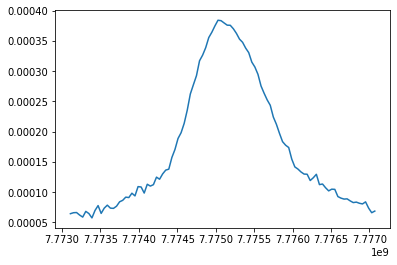

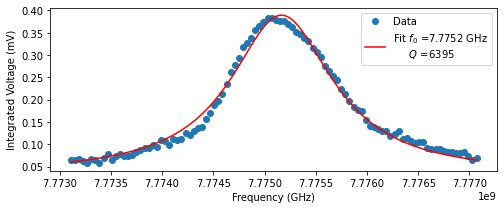


Resonator Frequency = 7795164914.265556


In [3]:

resonator_freq, avg_min_voltage, max_ro_voltage, smooth_dataset, dataset = ds.run_resonator_spectroscopy()

In [6]:
#save resonator params
print(diagnostics.get_config_parameter("settings", "", "resonator_freq"))
diagnostics.save_config_parameter("settings", "", "resonator_freq", float(resonator_freq))

print(diagnostics.get_config_parameter("settings", "", "resonator_spectroscopy_avg_min_ro_voltage"))
diagnostics.save_config_parameter("settings", "", "resonator_spectroscopy_avg_min_ro_voltage", float(avg_min_voltage))

print(diagnostics.get_config_parameter("settings", "", "resonator_spectroscopy_max_ro_voltage"))
diagnostics.save_config_parameter("settings", "", "resonator_spectroscopy_max_ro_voltage", float(max_ro_voltage))

print(diagnostics.get_config_parameter("LO_QRM_settings", "", "frequency"))
diagnostics.save_config_parameter("LO_QRM_settings", "", "frequency", float(resonator_freq - 20_000_000))


7795108893.499539
Saved value: 7795164914.265556
16.558676254943574
Saved value: 16.385041436795955
369.34690016364306
Saved value: 378.1358820360145
7775108893.49953
Saved value: 7775164914.265556


Qubit Spectroscopy

In [ ]:
qubit_freq, min_ro_voltage, smooth_dataset, dataset = ds.run_qubit_spectroscopy()

In [ ]:
#save qubit frequency founded - update LO_QCM freq + update qubit spec min voltage
print(diagnostics.get_config_parameter("settings", "", "qubit_freq"))
diagnostics.save_config_parameter("settings", "", "qubit_freq", float(qubit_freq))

print(diagnostics.get_config_parameter("LO_QCM_settings", "", "frequency"))
diagnostics.save_config_parameter("LO_QCM_settings", "", "frequency", float(qubit_freq + 200_000_000))

print(diagnostics.get_config_parameter("settings", "", "qubit_spectroscopy_min_ro_voltage"))
diagnostics.save_config_parameter("settings", "", "qubit_spectroscopy_min_ro_voltage", float(min_ro_voltage))

Rabi Oscillations with varying pulse length

In [ ]:
dataset, pi_pulse_duration, pi_pulse_amplitude, pi_pulse_gain, rabi_oscillations_pi_pulse_min_voltage, t1 = ds.run_rabi_pulse_length()


In [ ]:
#save pi pulse params founded + pi pulse min vol + T1
print(diagnostics.get_config_parameter("settings", "", "pi_pulse_duration"))
diagnostics.save_config_parameter("settings", "", "pi_pulse_duration", int(pi_pulse_duration))

print(diagnostics.get_config_parameter("settings", "", "pi_pulse_amplitude"))
diagnostics.save_config_parameter("settings", "", "pi_pulse_amplitude", float(pi_pulse_amplitude))

print(diagnostics.get_config_parameter("settings", "", "pi_pulse_gain"))
diagnostics.save_config_parameter("settings", "", "pi_pulse_gain", float(pi_pulse_gain))

print(diagnostics.get_config_parameter("settings", "", "rabi_oscillations_pi_pulse_min_voltage"))
diagnostics.save_config_parameter("settings", "", "rabi_oscillations_pi_pulse_min_voltage", float(rabi_oscillations_pi_pulse_min_voltage))

print(diagnostics.get_config_parameter("settings", "", "T1"))
#TODO: Double check T1 obtained from Rabi. It is not correct.
#diagnostics.save_config_parameter("settings", "", "T1", float(t1))

T1

In [ ]:
t1, smooth_dataset, dataset = ds.run_t1()

Ramsey

In [ ]:
t2, smooth_dataset, dataset = ds.run_ramsey()

Spin Echo

In [ ]:
dataset = ds.run_spin_echo()

In [ ]:
#Run Spin Echo 3 Pulses
dataset = ds.run_spin_echo_3pulses()
#TODO: The result of the plot does not match with the expected result
#        it should result in state |0> and it seems to give state |1>